# Implementing SIR with three strains in circulation
This conceptual model shows how an SIR model with three circulating strains could be implemented

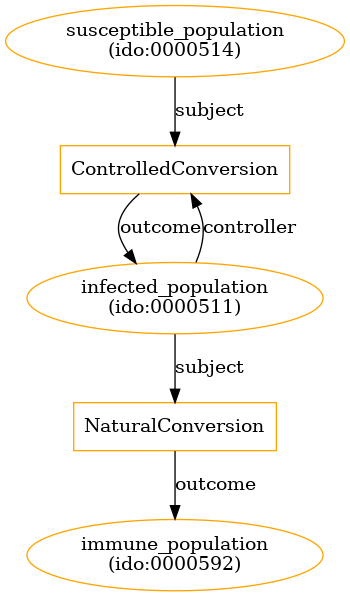

In [1]:
# Get an ready-made example SIR model that has parameters and initial values alrey set (note that the model is missing units)
from mira.examples.sir import sir_parameterized_init
from mira.metamodel import *
sir_parameterized_init.draw_jupyter()


## Stratify the model and allow re-infection from different strains
With three different strains in circulation, it is resonable to assume that there can be reinfection happening. Susceptible should remain unstratified.

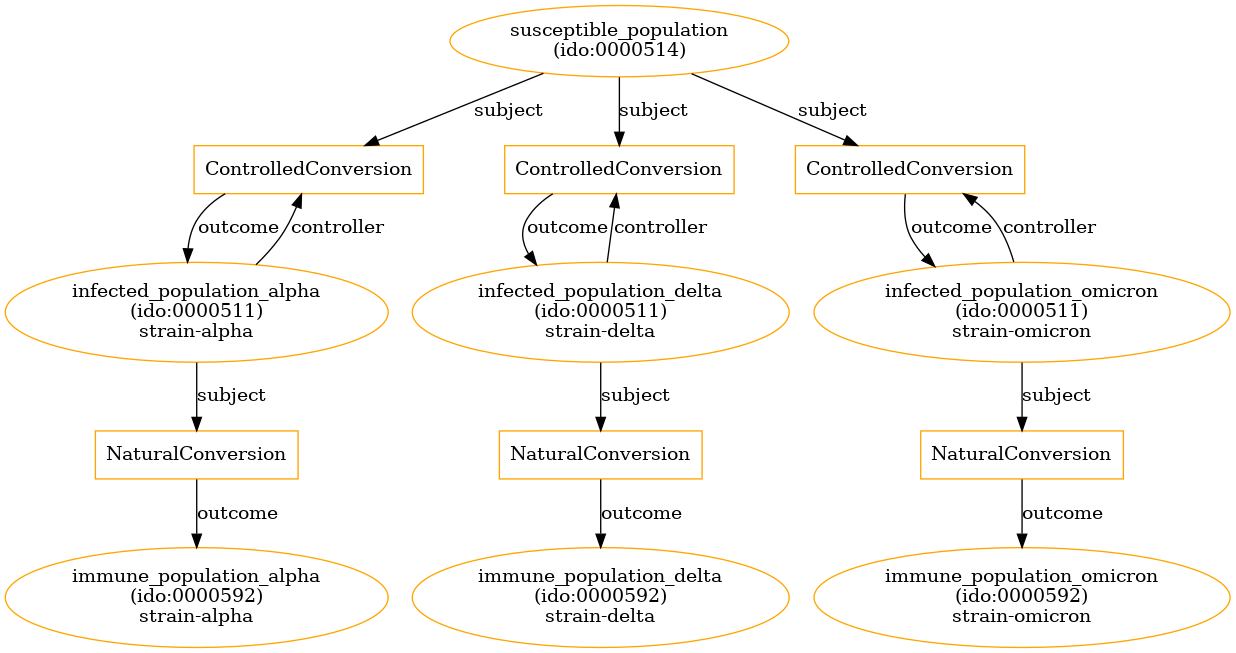

In [2]:
from mira.metamodel.ops import stratify
strains = ['alpha', 'delta', 'omicron']

# An empty list used for structure allows for three separate paths for each strain
strain_model = stratify(sir_parameterized_init, key='strain', strata=strains, concepts_to_preserve=['susceptible_population'], structure=[])
strain_model.draw_jupyter("sir.png")

## Add re-infection to other strains
Now we need to add reinfection to other strains, i.e. recovered/immune from alpha can be reinfected with delta or omicron strains and the other ways around, and after the first reinfection a second reinfection is possible from the remaining strain. Here we ignore the order in which strains infect subjects to simplify the case.

In [3]:
infected_alpha = strain_model.get_concepts_name_map()['infected_population_alpha']
infected_delta = strain_model.get_concepts_name_map()['infected_population_delta']
infected_omicron = strain_model.get_concepts_name_map()['infected_population_omicron']
recovered_alpha = strain_model.get_concepts_name_map()['immune_population_alpha']
recovered_delta = strain_model.get_concepts_name_map()['immune_population_delta']
recovered_omicron = strain_model.get_concepts_name_map()['immune_population_omicron']

# Get reinfected states and reinfected recovered states
# alpha delta
infected_alpha_delta = strain_model.get_concepts_name_map()['infected_population_alpha'].with_context(strain='alpha_delta')
infected_alpha_delta.name = 'infected_population_alpha_delta'
recovered_alpha_delta = strain_model.get_concepts_name_map()['immune_population_alpha'].with_context(strain='alpha_delta')
recovered_alpha_delta.name = 'immune_population_alpha_delta'

# alpha omicron
infected_alpha_omicron = strain_model.get_concepts_name_map()['infected_population_alpha'].with_context(strain='alpha_omicron')
infected_alpha_omicron.name = 'infected_population_alpha_omicron'
recovered_alpha_omicron = strain_model.get_concepts_name_map()['immune_population_alpha'].with_context(strain='alpha_delta')
recovered_alpha_omicron.name = 'immune_population_alpha_omicron'

# delta omicron
infected_delta_omicron = strain_model.get_concepts_name_map()['infected_population_delta'].with_context(strain='delta_omicron')
infected_delta_omicron.name = 'infected_population_delta_omicron'
recovered_delta_omicron = strain_model.get_concepts_name_map()['immune_population_alpha'].with_context(strain='delta_omicron')
recovered_delta_omicron.name = 'immune_population_delta_omicron'

# alpha delta omicron (third and final infection for any branch)
infected_alpha_delta_omicron = strain_model.get_concepts_name_map()['infected_population_alpha'].with_context(strain='alpha_delta_omicron')
infected_alpha_delta_omicron.name = 'infected_population_alpha_delta_omicron'
recovered_alpha_delta_omicron = strain_model.get_concepts_name_map()['immune_population_alpha'].with_context(strain='alpha_delta_omicron')
recovered_alpha_delta_omicron.name = 'immune_population_alpha_delta_omicron'

In [4]:
# Create infections from other strains and set their rates
new_templates = []
new_parameters = {}

# alpha/omicron -> delta infection (i.e. gain a delta infection)
for rec_name, subject, outcome, recovery in [
        ('alpha', recovered_alpha, infected_alpha_delta, recovered_alpha_delta),
        ('omicron', recovered_omicron, infected_delta_omicron, recovered_delta_omicron),
        ('alpha_omicron', recovered_alpha_omicron, infected_alpha_delta_omicron, recovered_alpha_delta_omicron),
]:
    for name, infector in [
            ('delta', infected_delta),
            ('alpha_delta', infected_alpha_delta),
            ('delta_omicron', infected_delta_omicron),
            ('alpha_delta_omicron', infected_alpha_delta_omicron)
    ]:
        cc = ControlledConversion(
            subject=subject,
            controller=infector,
            outcome=outcome
        )
        param_name = f"beta_{rec_name}_{name}"
        cc.set_mass_action_rate_law(param_name)
        new_parameters[param_name] = Parameter(name=param_name, value=1)
        new_templates.append(cc)

        nc = NaturalConversion(
            subject=outcome,
            outcome=recovery
        )
        param_name_rec = f"gamma_{name}"
        nc.set_mass_action_rate_law(param_name_rec)
        new_parameters[param_name] = Parameter(name=param_name_rec, value=1)
        new_templates.append(nc)


# delta/omicron -> alpha infection (i.e. gain alpha infection)
for rec_name, subject, outcome, recovery in [
        ('delta', recovered_delta, infected_alpha_delta, recovered_alpha_delta),
        ('omicron', recovered_omicron, infected_alpha_omicron, recovered_alpha_omicron),
        ('delta_omicron', recovered_delta_omicron, infected_alpha_delta_omicron, None),
]:
    for name, infector in [
            ('alpha', infected_alpha),
            ('alpha_delta', infected_alpha_delta),
            ('alpha_omicron', infected_alpha_omicron),
            ('alpha_delta_omicron', infected_alpha_delta_omicron)
    ]:
        cc = ControlledConversion(
            subject=subject,
            controller=infector,
            outcome=outcome
        )
        param_name = f"beta_{rec_name}_{name}"
        cc.set_mass_action_rate_law(param_name)
        new_parameters[param_name] = Parameter(name=param_name, value=1)
        new_templates.append(cc)
        
        if recovery is not None:
            nc = NaturalConversion(
                subject=outcome,
                outcome=recovery
            )
            param_name_rec = f"gamma_{name}"
            nc.set_mass_action_rate_law(param_name_rec)
            new_parameters[param_name_rec] = Parameter(name=param_name_rec, value=1)
            new_templates.append(nc)


# alpha/delta -> omicron infection (i.e. gain omicron infection)
for rec_name, subject, outcome, recovery in [
        ('alpha', recovered_alpha, infected_alpha_omicron, recovered_alpha_omicron),
        ('delta', recovered_delta, infected_delta_omicron, recovered_delta_omicron),
        ('alpha_delta', recovered_alpha_delta, infected_alpha_delta_omicron, None),
]:
    for name, infector in [
            ('omicron', infected_omicron),
            ('alpha_omicron', infected_alpha_omicron),
            ('delta_omicron', infected_delta_omicron),
            ('alpha_delta_omicron', infected_alpha_delta_omicron)
    ]:
        cc = ControlledConversion(
            subject=subject,
            controller=infector,
            outcome=outcome
        )
        param_name = f"beta_{rec_name}_{name}"
        cc.set_mass_action_rate_law(param_name)
        new_parameters[param_name] = Parameter(name=param_name, value=1)
        new_templates.append(cc)

        if recovery is not None:
            nc = NaturalConversion(
                subject=outcome,
                outcome=recovery,
            )
            param_name_rec = f"gamma_{name}"
            nc.set_mass_action_rate_law(param_name_rec)
            new_parameters[param_name_rec] = Parameter(name=param_name, value=1)
            new_templates.append(nc)

extenstion_tm = TemplateModel(templates=new_templates, parameters=new_parameters)

total_tm = strain_model.extend(extenstion_tm, parameter_mapping=new_parameters)

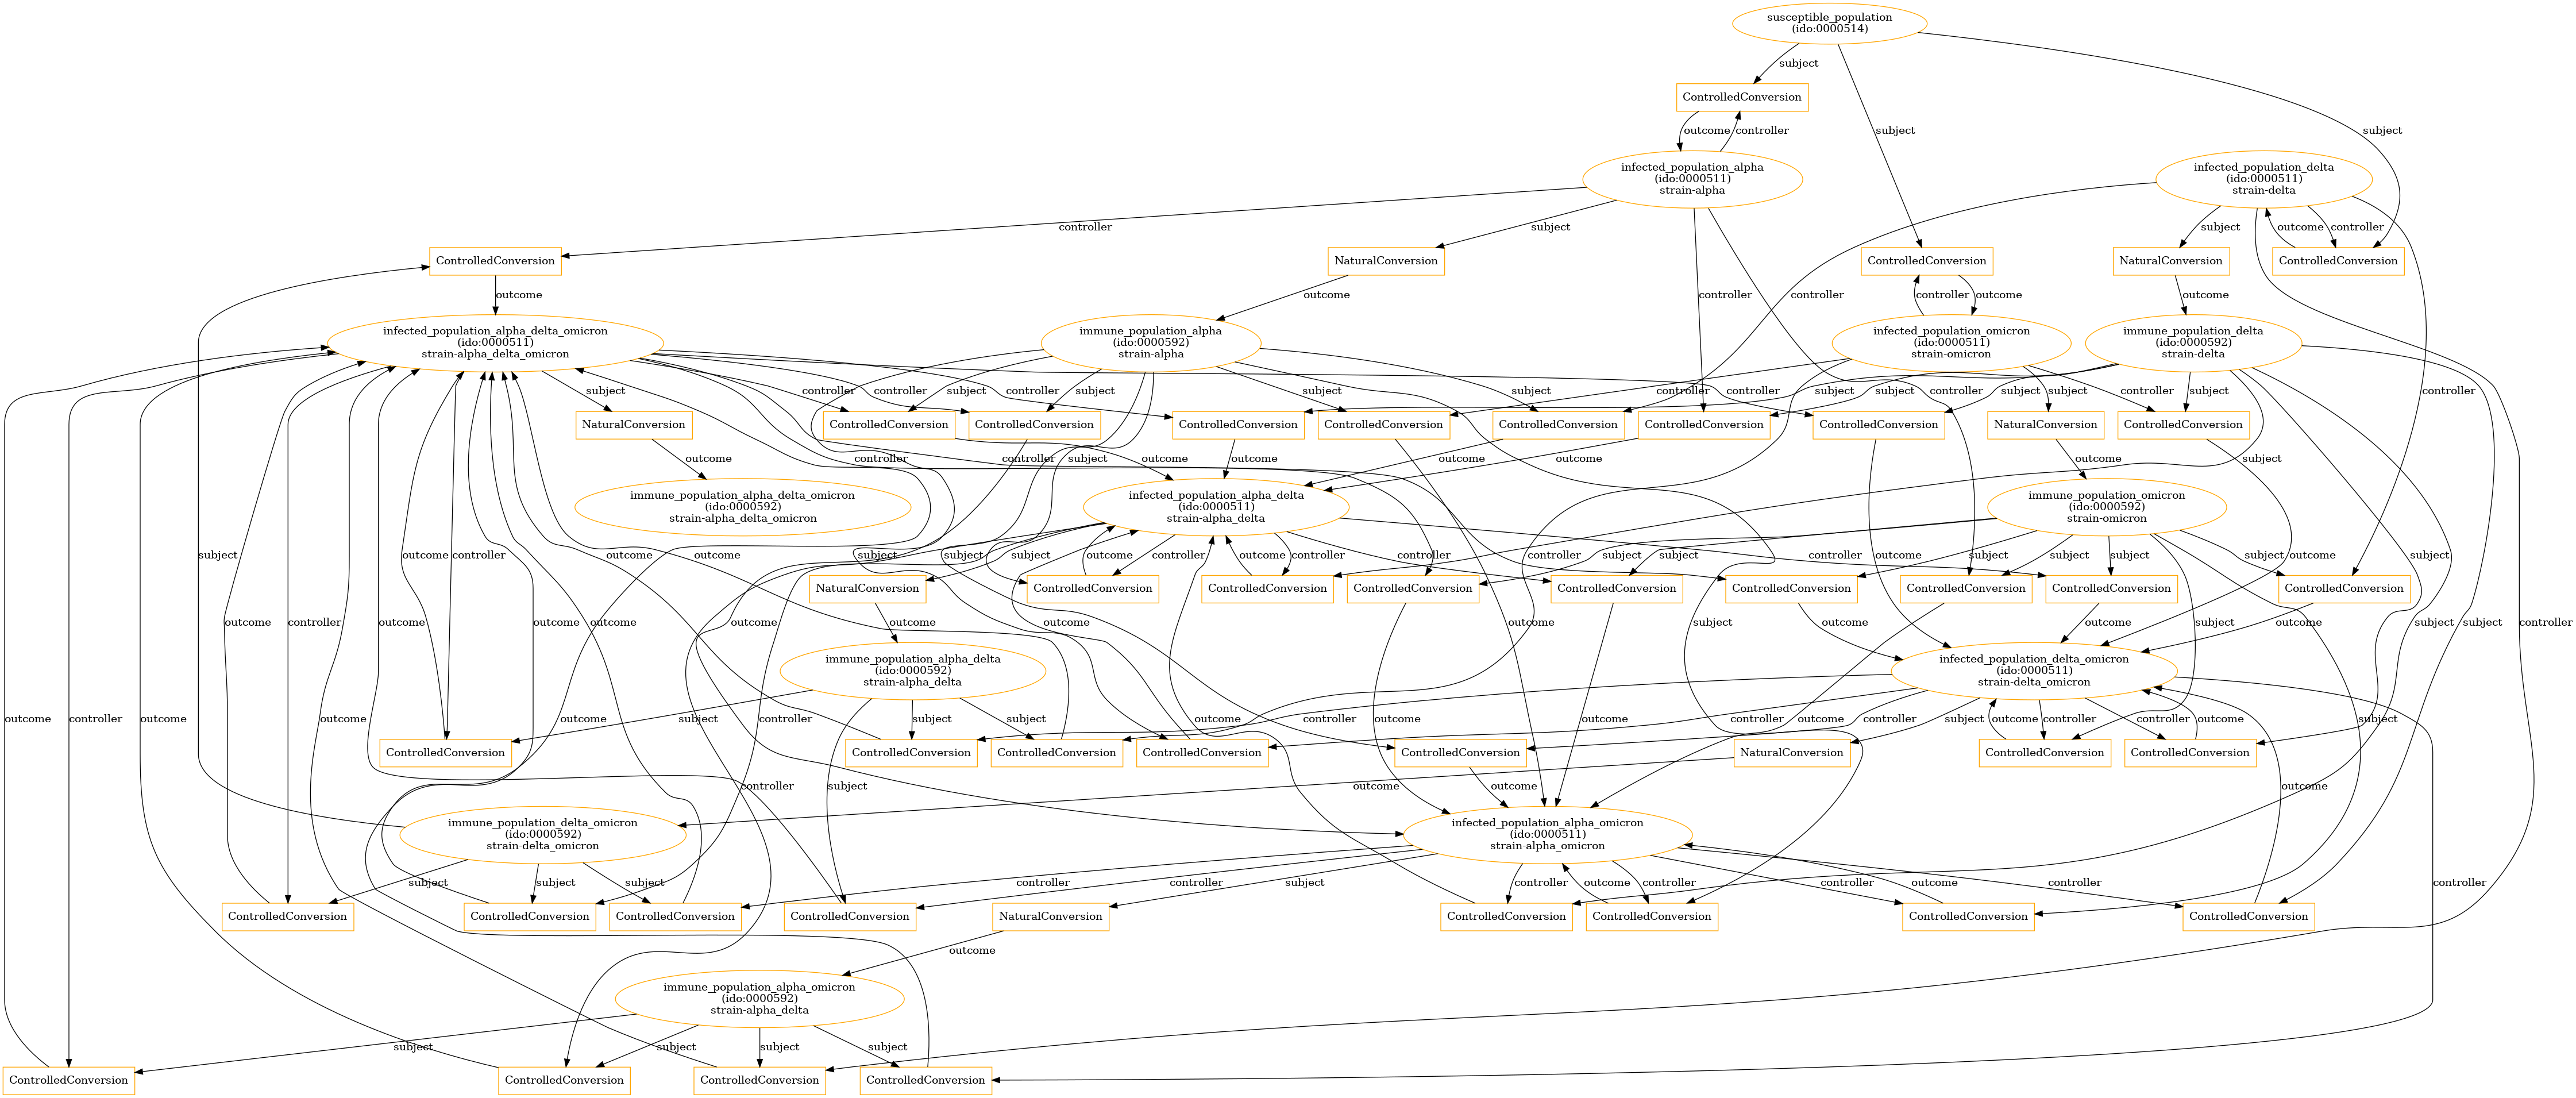

In [5]:
import json
from mira.modeling.amr.regnet import template_model_to_regnet_json
from mira.modeling.amr.petrinet import template_model_to_petrinet_json
for out_type, out_fun in [('regnet', template_model_to_regnet_json), ('petrinet', template_model_to_petrinet_json)]:
    with open(f"sir_3strain_{out_type}.json", 'w') as f:
        json.dump(out_fun(total_tm), f, indent=2)
total_tm.draw_jupyter("sir_3strain.png")